In [4]:
# Import needed packages for analysis
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from scipy.stats import kendalltau

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV
import cfl.util.fear_mice_functions as fm 


behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'
mri_dir = 'PTSD_Data_Share\MEMRI_data'

# load one image to check out its dimensions
img = BU.load_brain(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"))
mri_dims = img.shape
print(mri_dims)

# load one image to get affine
nib_img = nib.load(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"))
affine = nib_img.affine

# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path, ori='RPS')
nolin_mask_vec = BU.flatten(nl_mask)


# specify labels for plot (note the labels below are specifically for RAS orientation)
dir_labels = { 'saggital' :   ['P', 'A', 'D', 'V'],
               'coronal' :    ['L', 'R', 'D', 'V'],
               'horizontal' : ['L', 'R', 'A', 'P']} 


(124, 200, 82)


In [5]:
# load response data 
Y = pd.read_pickle('Y.pkl')

In [6]:
# load MRI data 
X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, ori='RPS')

In [7]:
# gaussian smooth image in X using a kernel size of (3, 3, 3) voxels 
# some further info about smoothing MRIs: http://jpeelle.net/mri/image_processing/smoothing.html 

X_smooth = np.zeros(X.shape)
for i, image in enumerate(X): 
    unflatten = BU.unflatten(image, mri_dims)
    smooth = gaussian_filter(unflatten, sigma=(3, 3, 3), mode='nearest')
    X_smooth[i] = BU.flatten(smooth)

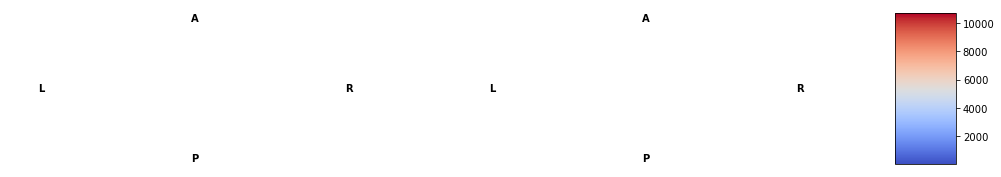

In [8]:
BV.plot_interactive_panels(X_smooth[:2], mri_dims, nolin_mask_vec, figsize=(17, 3), dir_labels=dir_labels)

In [17]:
#save smoothed array 
np.save('X_smooth3.npy', X_smooth)

In [18]:
np.any(np.isnan(X_smooth))

False

## Compute correlations again on smoothed data 

Both Pearson and Kendall, for KO and WT mice separate

In [19]:
X_smooth = np.load(os.path.join('X_smooth3.npy'))

In [21]:
# KO correlations
# Fear - pre-fear behavior
 
indices_dir = fm.geno_time_indices_dir(Y)

Y_KO_diffs = Y.PerLight[indices_dir['Fear_KO']].to_numpy() - Y.PerLight[indices_dir['PreF_KO']].to_numpy()

X_KO_diffs = X_smooth[indices_dir['Fear_KO']] - X_smooth[indices_dir['PreF_KO']]

corrs_KO = np.zeros(X.shape[1])

for voxel in range(X.shape[1]): 
    value = pearsonr(Y_KO_diffs, X_KO_diffs[:, voxel])[0]
    if np.isnan(value): #if x is all 0s, pearson returns a nan
        value = 0 
    corrs_KO[voxel] = value

np.save(os.path.join("corrs_smooth_KO.npy"), corrs_KO)

# WT correlations
#Fear - pre-fear behavior
Y_WT_diffs = Y.PerLight[indices_dir['Fear_WT']].to_numpy() - Y.PerLight[indices_dir['PreF_WT']].to_numpy()

X_WT_diffs = X_smooth[indices_dir['Fear_WT']] - X_smooth[indices_dir['PreF_WT']]

corrs_WT = np.zeros(X.shape[1])

for voxel in range(X.shape[1]): 
    value = pearsonr(Y_WT_diffs, X_WT_diffs[:, voxel])[0]
    if np.isnan(value): 
        value = 0 
    corrs_WT[voxel] = value

np.save(os.path.join("corrs_smooth_WT.npy"), corrs_WT)
#note: when everything is a 0, pearsonr returns a nan correlation value

In [28]:
corrs_KO = np.load('corrs_smooth_KO.npy')
corrs_WT = np.load('corrs_smooth_WT.npy')

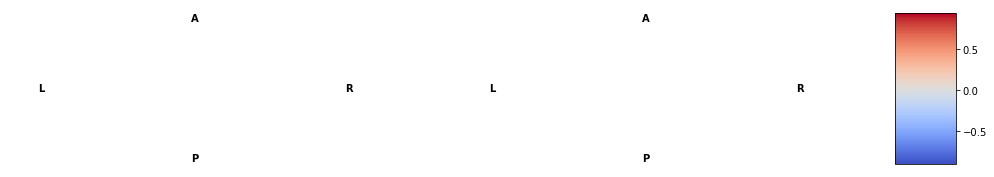

In [36]:
BV.plot_interactive_panels(np.vstack((corrs_KO, corrs_WT)), mri_dims, nolin_mask_vec, figsize=(17, 3), dir_labels=dir_labels, column_titles=["Pearson Corrs for KO Mice", "Pearson Corrs for WT Mice"])

## Kendall Correlations

In [34]:
# KO correlations
# Fear - pre-fear behavior
 
indices_dir = fm.geno_time_indices_dir(Y)

Y_KO_diffs = Y.PerLight[indices_dir['Fear_KO']].to_numpy() - Y.PerLight[indices_dir['PreF_KO']].to_numpy()

X_KO_diffs = X_smooth[indices_dir['Fear_KO']] - X_smooth[indices_dir['PreF_KO']]

kcorrs_KO = np.zeros(X.shape[1])

for voxel in range(X.shape[1]): 
    value = kendalltau(Y_KO_diffs, X_KO_diffs[:, voxel])[0]
    if np.isnan(value): #if x is all 0s, pearson returns a nan
        value = 0 
    kcorrs_KO[voxel] = value

np.save(os.path.join("kcorrs_smooth_KO.npy"), kcorrs_KO)

# WT correlations
#Fear - pre-fear behavior
Y_WT_diffs = Y.PerLight[indices_dir['Fear_WT']].to_numpy() - Y.PerLight[indices_dir['PreF_WT']].to_numpy()

X_WT_diffs = X_smooth[indices_dir['Fear_WT']] - X_smooth[indices_dir['PreF_WT']]

kcorrs_WT = np.zeros(X.shape[1])

for voxel in range(X.shape[1]): 
    value = kendalltau(Y_WT_diffs, X_WT_diffs[:, voxel])[0]
    if np.isnan(value): 
        value = 0 
    kcorrs_WT[voxel] = value

np.save(os.path.join("kcorrs_smooth_WT.npy"), kcorrs_WT)
#note: when everything is a 0, pearsonr returns a nan correlation value

In [ ]:
kcorrs_KO = np.load(os.path.join('kcorrs_smooth_KO.npy'))
kcorrs_WT = np.load(os.path.join('kcorrs_smooth_WT.npy'))

In [32]:
corrs_KO.shape

(2033600,)

In [33]:
fm.save_as_nifti(corrs_KO, 'corrs_smooth_KO.nii', mri_dims, affine)
fm.save_as_nifti(corrs_WT, 'corrs_smooth_WT.nii', mri_dims, affine)
# fm.save_as_nifti(kcorrs_KO, 'kcorrs_smooth_KO.nii', mri_dims, affine)
# fm.save_as_nifti(kcorrs_WT, 'kcorrs_smooth_WT.nii', mri_dims, affine)